## Imports and Options

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.regularizers import l1_l2
from sklearn.metrics import accuracy_score
from collections import OrderedDict, Counter
from tensorflow.python.ops import gen_array_ops
from keras.layers import Dense, Dropout, Flatten
from names import Names as n

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)
matplotlib.use("tkagg")
%matplotlib inline

In [3]:
col_idx = OrderedDict([(n.label, 0), ("inducer_concentration", 1), ("timepoint", 2), ("percent_live", 3)])

## Utility Functions

In [4]:
def training_progress(fitted_model, metrics, num_plots, loss_name, plot_val=None):
    '''
    A function for plotting the model history by showing the metric and loss throughout training
    '''
    plt.subplot(1, num_plots, 2)
    plt.plot(fitted_model.history['loss'], label='train loss')
    if plot_val is not None:
        plt.plot(fitted_model.history['val_loss'], label='val loss')
    plt.title('Loss ({})'.format(loss_name))
    plt.legend()

    for i, metric in enumerate(metrics):
        subplot_number = i + 3
        plt.subplot(1, num_plots, subplot_number)
        plt.plot(fitted_model.history[metric], label=str(metric))
        if plot_val is not None:
            plt.plot(fitted_model.history[f'val_{metric}'], label=f'val_{metric}')
        plt.title(str(metric))
        plt.legend()

    plt.show()


def plot_model_result(model, fitted_model, metrics, X, loss_name, plot_val=None):
    '''
    plot the foe_probabilities of a model
    plot the training history
    show training accuracy
    '''
    num_plots = len(metrics) + 2
    probas = model.predict_proba(X)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, num_plots, 1)
    plt.hist(probas)
    plt.xlabel('predict_proba')
    training_progress(fitted_model, metrics, num_plots, loss_name, plot_val)

## Prepare Data

### Set Features

In [14]:
features = n.morph_cols

### Full Data

In [15]:
df_all = pd.read_csv("models/cfu_neural_network/df_for_testing.csv")

X_all = df_all[features]
Y_all = df_all[col_idx.keys()]
all_labels = df_all[n.label]

print(df_all.shape)
print(X_all.shape)
print(Y_all.shape)
print(all_labels.shape)

(259542, 11)
(259542, 6)
(259542, 4)
(259542,)


### Subsets of Data

In [16]:
df_5_1 = df_all.loc[(df_all[n.inducer_concentration].isin([5.0])) & 
                    (df_all[n.timepoint].isin([1.0]))].copy()

X_5_1 = df_5_1[features]
Y_5_1 = df_5_1[col_idx.keys()]

print(df_5_1.shape)
print(X_5_1.shape)
print(Y_5_1.shape)

(1500, 11)
(1500, 6)
(1500, 4)


In [22]:
df_2_extremes = df_all.loc[(df_all[n.inducer_concentration].isin([0.0, 80.0,])) & 
                           (df_all[n.timepoint].isin([6.0]))].copy()
first = df_2_extremes[df_2_extremes[n.inducer_concentration]==0.0].sample(1000)
second = df_2_extremes[df_2_extremes[n.inducer_concentration]==80.0].sample(1000)
df_2_extremes = pd.concat([first, second])

X_2_extremes = df_2_extremes[features]
Y_2_extremes = df_2_extremes[col_idx.keys()]

print(df_2_extremes.shape)
print(X_2_extremes.shape)
print(Y_2_extremes.shape)

(2000, 11)
(2000, 6)
(2000, 4)


## Losses

In [143]:
def bin_cross(label_conds_cfus, y_pred):
    y_pred = K.flatten(y_pred)
    y_true = label_conds_cfus[:, col_idx[n.label]]
    final_loss = tf.losses.binary_crossentropy(y_true=y_true, y_pred=y_pred)
    return final_loss

In [144]:
def cfu_loss(label_conds_cfus, y_pred):
    cfu_percent_live = label_conds_cfus[:, col_idx["percent_live"]]
    cfu_percent_live = cfu_percent_live / 100.0
    condition_indices = [col_idx["inducer_concentration"], col_idx["timepoint"]]
    conditions = tf.gather(label_conds_cfus, condition_indices, axis=1)
    y_pred = K.flatten(y_pred)
    y_pred = tf.sigmoid((y_pred - 0.5) * 100)
    uniques, idx, count = gen_array_ops.unique_with_counts_v2(conditions, [0])
    num_unique = tf.size(count)
    pred_percents = tf.math.unsorted_segment_mean(data=y_pred, segment_ids=idx, num_segments=num_unique)
    cfu_percents = tf.math.unsorted_segment_mean(data=cfu_percent_live, segment_ids=idx, num_segments=num_unique)
    diff = tf.math.subtract(pred_percents, cfu_percents)
    abs_diff = K.abs(diff)
    abs_diff_mean = tf.math.reduce_mean(abs_diff)
    return abs_diff_mean

In [145]:
def joint_loss_wrapper(cfu_loss_weight):
    
    def joint_loss(label_conds_cfus, y_pred):
        loss_bin_cross = bin_cross(label_conds_cfus=label_conds_cfus, y_pred=y_pred)
        loss_cfu = cfu_loss(label_conds_cfus=label_conds_cfus, y_pred=y_pred)
        return loss_bin_cross + cfu_loss_weight*loss_cfu
    
    return joint_loss

In [146]:
# def joint_loss_2(label_conds_cfus, y_pred):
#     loss_bin_cross = bin_cross(label_conds_cfus=label_conds_cfus, y_pred=y_pred)
#     loss_cfu = cfu_loss(label_conds_cfus=label_conds_cfus, y_pred=y_pred)
#     return loss_bin_cross + 2*loss_cfu

## Models

In [51]:
def booster_model_v1(input_shape=None, loss=joint_loss, metrics=None, lr=0.01):
    if metrics is None:
        metrics = [loss]
    model = Sequential()
    model.add(Dropout(0.1, input_shape=(input_shape,)))
    # wr = l1_l2(l2=0.02, l1=0)
    wr = None
    model.add(Dense(units=32, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.3))
    model.add(Dense(units=16, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    model.add(Dense(units=8, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    model.add(Dense(units=4, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    # wr = l1_l2(l2=0.02, l1=0)
    model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=wr))
    model.add(Flatten())
    model.compile(loss=loss, optimizer=Adam(lr=lr),
                  metrics=metrics, run_eagerly=True)
    # TODO: figure out how to add accuracy to metrics. Not trivial due to 4D nature of our Y.
    return model

In [52]:
def booster_model_v2(input_shape=None, loss=joint_loss, metrics=None, lr=0.1):
    if metrics is None:
        metrics = [loss]
    
    model = Sequential()
    model.add(Dense(units=32, activation="relu", input_shape=(input_shape,)))
    model.add(Dropout(0.1))
    model.add(Dense(units=16, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(units=8, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss=loss, optimizer=Adam(lr=lr),
                  metrics=metrics, run_eagerly=True)
    return model

## Wrappers and Results Functions

In [175]:
def run_model(model_function, lr, loss, metrics, X, Y, epochs, batch_size, verbose, shuffle, plot_type="scatter"):
    # reset model each time
    tf.compat.v1.reset_default_graph
    tf.keras.backend.clear_session()
    
    # create model
    model = model_function(input_shape=len(features), loss=loss, metrics=metrics, lr=lr)
    print(model.summary())
    
    # fit model and predict
    start_time = time.time()
    fitted_model = model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=shuffle)
    predict_proba = model.predict(X)
    class_predictions = np.ndarray.flatten(predict_proba > 0.5).astype("int32")
    
    # print metrics
    training_accuracy = accuracy_score(y_true=Y[n.label], y_pred=class_predictions)
    print("\nModel Boosting took {} seconds".format(time.time() - start_time))
    print("Training Accuracy = {}%".format(round(100 * training_accuracy, 2)))
    print(Counter(class_predictions))
    
    # plot probabilities and losses
    plot_model_result(model=model, fitted_model=fitted_model,
                      metrics=[x.__name__ for x in metrics],
                      X=X, loss_name=loss.__name__, plot_val=None)
    
    # print summary of predictions vs. cfus
    preds_and_labels = Y.copy()
    preds_and_labels[n.label] = preds_and_labels[n.label] * 100
    preds_and_labels["nn_preds"] = class_predictions * 100
    preds_and_labels.rename(columns={"percent_live":"cfu_percent_live"}, inplace=True)
    groupby_means = preds_and_labels.groupby([n.inducer_concentration, n.timepoint]).mean()
    # print(groupby_means)
    
    condition_results = groupby_means.reset_index()
        
    # plot percent live over conditions
    plot_percent_live_over_conditions(condition_results, plot_type)

    return condition_results, preds_and_labels

In [159]:
def plot_percent_live_over_conditions(condition_results, plot_type="scatter", 
                                      color_by=n.inducer_concentration, fig_height=10):
    percent_live_df = condition_results
    
    plt.figure(figsize=(15, fig_height))
    sns.set(style="ticks", font_scale=1.2, rc={"lines.linewidth": 3.0})
    color_levels = list(percent_live_df[color_by].unique())
    color_levels.sort()
    num_colors = len(color_levels)
    palette = dict(zip(color_levels, sns.color_palette("bright", num_colors)))
    
    if plot_type == "line":
#         labels = sns.lineplot(x=percent_live_df[n.timepoint], y=percent_live_df[n.label],
#                       hue=percent_live_df[color_by], 
#                       palette=palette, legend=False, zorder=1, style=True, dashes=[(2,2)])

        preds = sns.lineplot(x=percent_live_df[n.timepoint], y=percent_live_df["nn_preds"],
                          hue=percent_live_df[color_by], 
                          palette=palette, legend="full", zorder=1)
        
        cfus = sns.scatterplot(x=percent_live_df[n.timepoint], y=percent_live_df["cfu_percent_live"],
                   hue=percent_live_df[color_by], 
                   palette=palette, legend=False, zorder=1, s=250, marker="o")

    elif plot_type == "scatter":
        labels = sns.scatterplot(x=percent_live_df[n.timepoint]-0.14, y=percent_live_df[n.label],
                                 hue=percent_live_df[color_by], 
                                 palette=palette, legend="full", zorder=1, s=250, marker="s")

        preds = sns.scatterplot(x=percent_live_df[n.timepoint], y=percent_live_df["nn_preds"],
                                hue=percent_live_df[color_by], 
                                palette=palette, legend=False, zorder=1, s=250, marker="^")
        
        cfus = sns.scatterplot(x=percent_live_df[n.timepoint]+0.14, y=percent_live_df["cfu_percent_live"],
                           hue=percent_live_df[color_by], 
                           palette=palette, legend=False, zorder=1, s=250, marker="o")


    # visual settings
    plt.xlim(0, 6.5)
    plt.ylim(-5, 105)
    plt.title("Square = Label Percent Live\nTriangle = Predicted Percent Live\nCircle = CFU Percent Live")
    legend = plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2, borderaxespad=0.,
                        handlelength=4, markerscale=1.8)
    legend.get_frame().set_edgecolor('black')

## Test Model and Losses

### CFU Loss - 2 conditions


Model Boosting took 16.88230800628662 seconds
Training Accuracy = 95.35%
Counter({1: 1060, 0: 940})


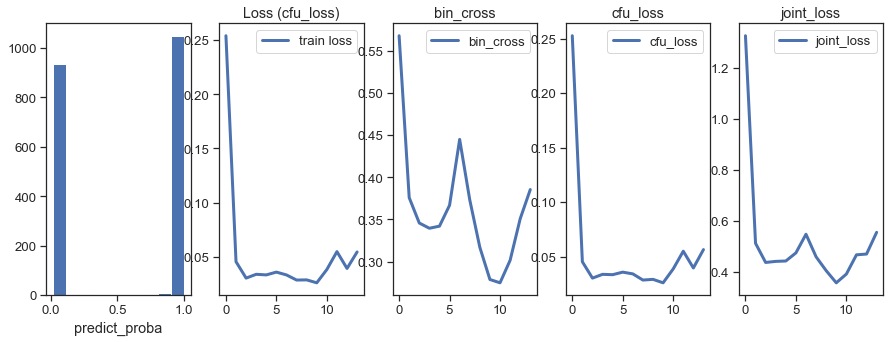

                                 label  cfu_percent_live  nn_preds
inducer_concentration timepoint                                   
0.0                   6.0         96.4             100.0      99.7
80.0                  6.0          0.3               0.0       6.3


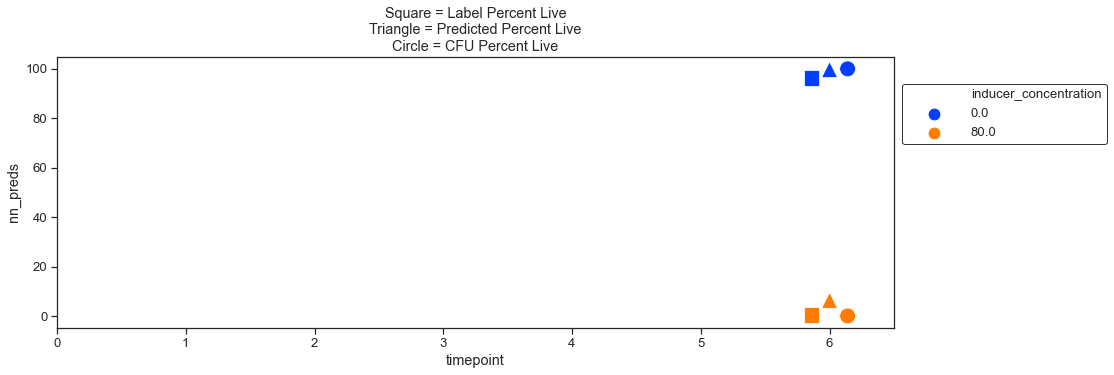

In [87]:
_,_ = run_model(model_function=booster_model_v2, lr=0.01,
          loss = cfu_loss, metrics = [bin_cross, cfu_loss, joint_loss],
          X = X_2_extremes, Y = Y_2_extremes, epochs = 14, batch_size = 32, 
          verbose = False, shuffle = True, plot_type="scatter")

In [88]:
# Flipping the percent_live values to see if cfu_loss can reverse the way it nudges predictions.
flipped_df = df_2_extremes.copy()
flipped_df.loc[flipped_df[n.percent_live] == 0.0, n.percent_live] = 90.0
flipped_df.loc[flipped_df[n.percent_live] == 100.0, n.percent_live] = 10.0

X_flipped = flipped_df[features]
Y_flipped = flipped_df[col_idx.keys()]


Model Boosting took 16.604356050491333 seconds
Training Accuracy = 4.8%
Counter({0: 1063, 1: 937})


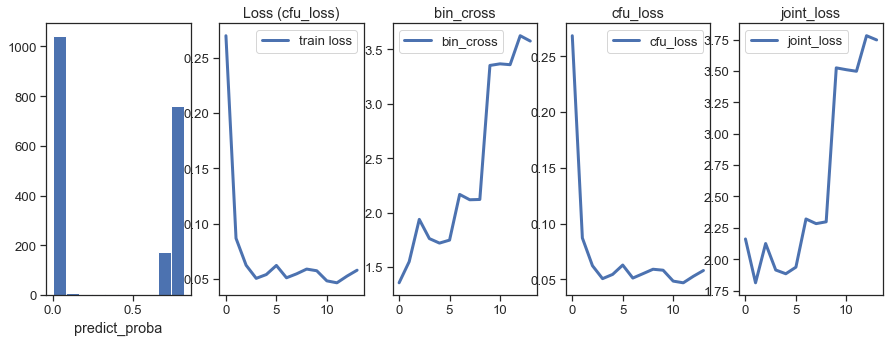

                                 label  cfu_percent_live  nn_preds
inducer_concentration timepoint                                   
0.0                   6.0         96.4              10.0       0.3
80.0                  6.0          0.3              90.0      93.4


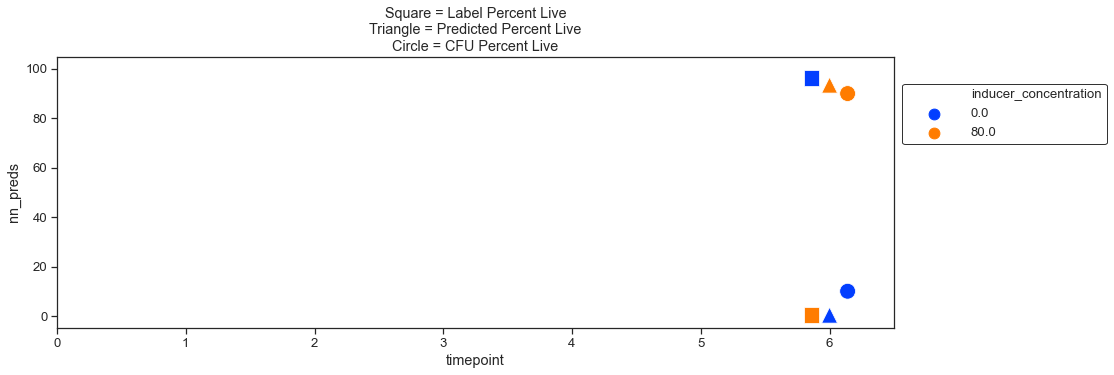

In [89]:
_,_ = run_model(model_function=booster_model_v2, lr=0.01,
                loss = cfu_loss, metrics = [bin_cross, cfu_loss, joint_loss],
                X = X_flipped, Y = Y_flipped, epochs = 14, batch_size = 32,
                verbose = False, shuffle = True)

### Joint Loss - 2 conditions


Model Boosting took 18.104620933532715 seconds
Training Accuracy = 96.75%
Counter({1: 1030, 0: 970})


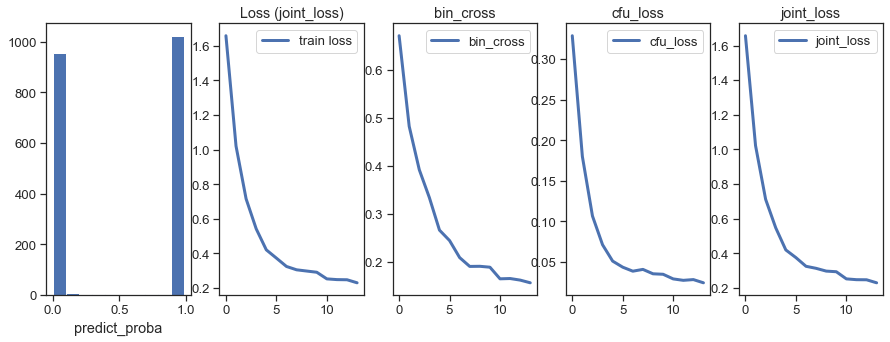

                                 label  cfu_percent_live  nn_preds
inducer_concentration timepoint                                   
0.0                   6.0         96.4             100.0      99.5
80.0                  6.0          0.3               0.0       3.5


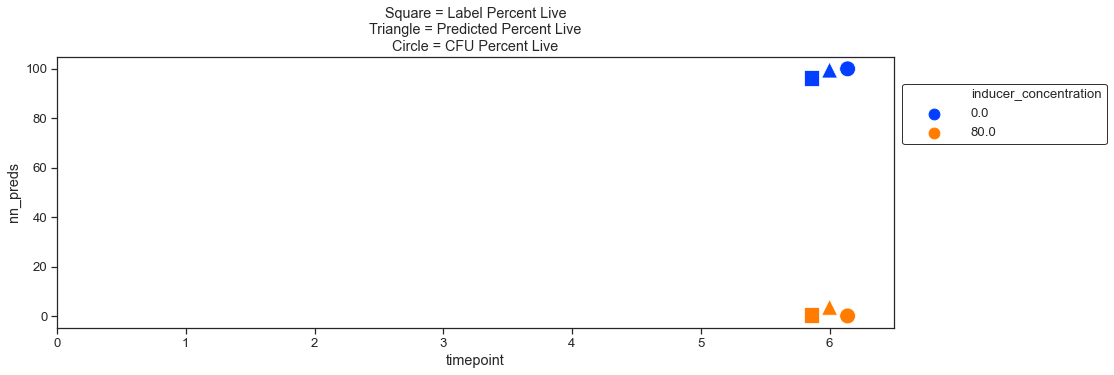

In [92]:
_,_ = run_model(model_function=booster_model_v2, lr=0.001,
                loss = joint_loss, metrics = [bin_cross, cfu_loss, joint_loss],
                X = X_2_extremes, Y = Y_2_extremes, epochs = 14, batch_size = 32, 
                verbose = False, shuffle = True)


Model Boosting took 18.413615226745605 seconds
Training Accuracy = 3.05%
Counter({0: 1026, 1: 974})


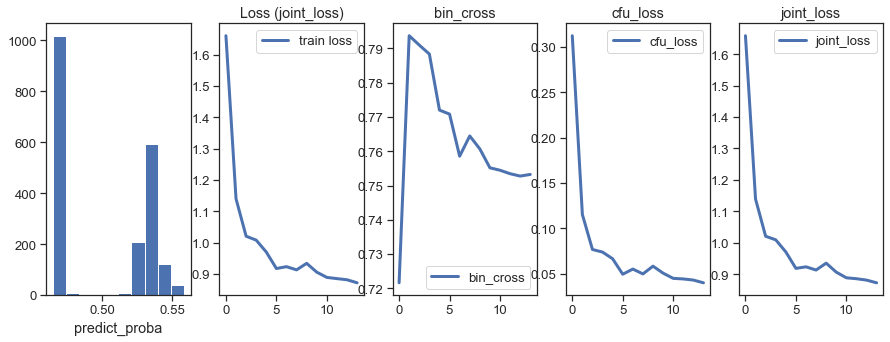

                                 label  cfu_percent_live  nn_preds
inducer_concentration timepoint                                   
0.0                   6.0         96.4              10.0       0.5
80.0                  6.0          0.3              90.0      96.9


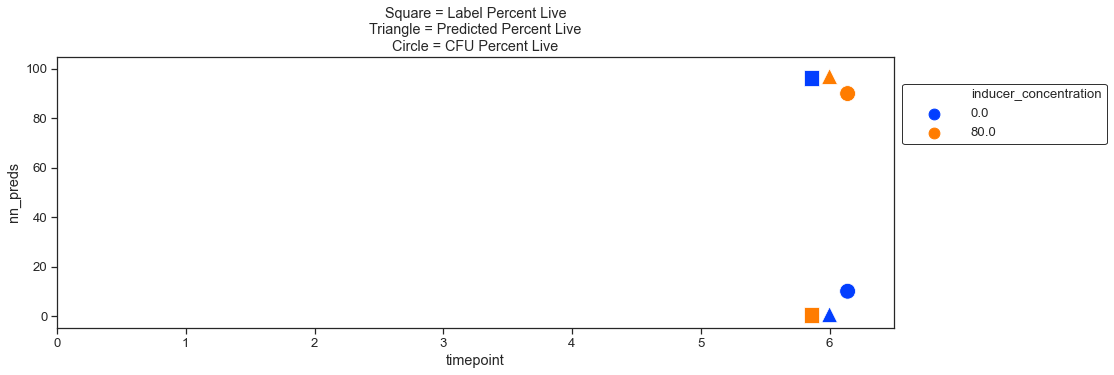

In [93]:
_,_ = run_model(model_function=booster_model_v2, lr=0.001,
                loss = joint_loss, metrics = [bin_cross, cfu_loss, joint_loss],
                X = X_flipped, Y = Y_flipped, epochs = 14, batch_size = 32,
                verbose = False, shuffle = True)

### Joint Loss - All Conditions


Model Boosting took 172.61974787712097 seconds
Training Accuracy = 87.98%
Counter({0: 151898, 1: 107644})


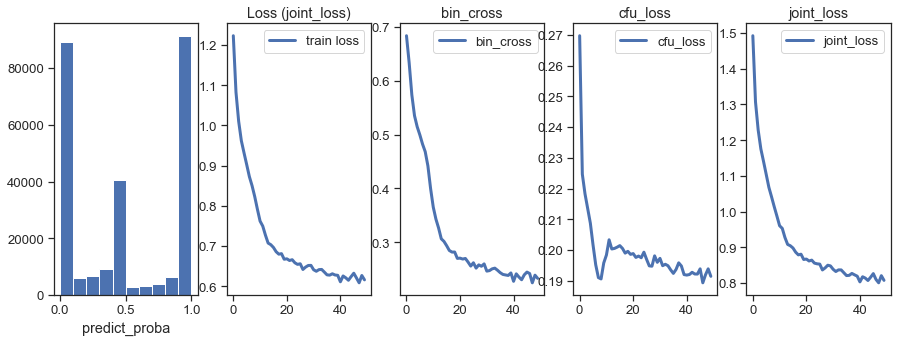

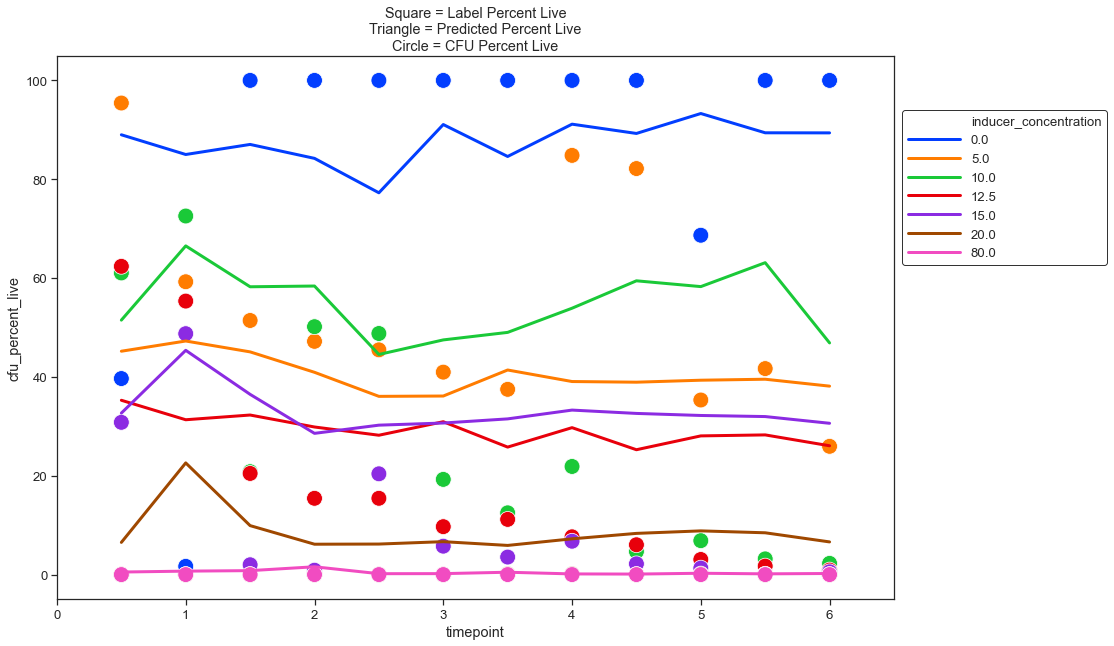

In [172]:
condition_results, preds_and_labels = run_model(model_function=booster_model_v2, lr=0.001,
                             loss = joint_loss_wrapper(2), metrics = [bin_cross, cfu_loss, joint_loss],
                             X = X_all, Y = Y_all, epochs = 50, batch_size = 2048,
                             verbose = False, shuffle = True, plot_type="line")

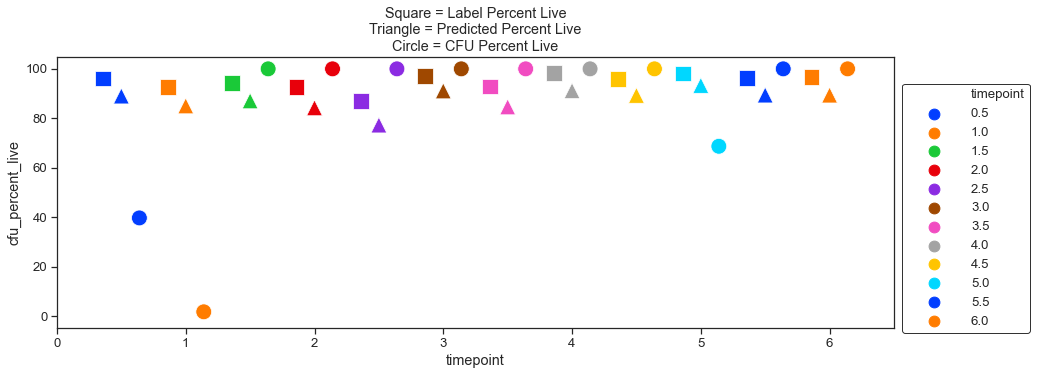

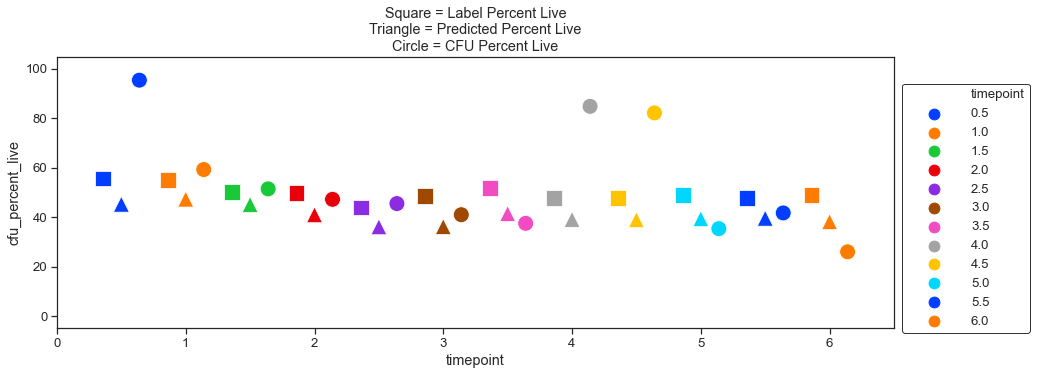

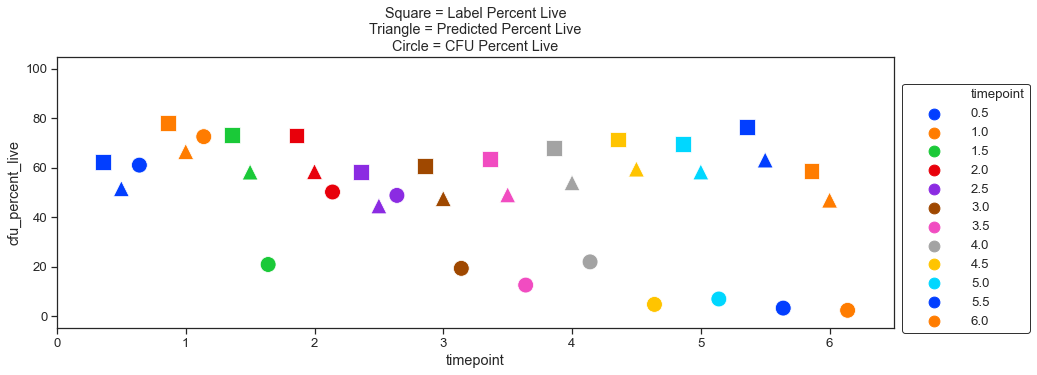

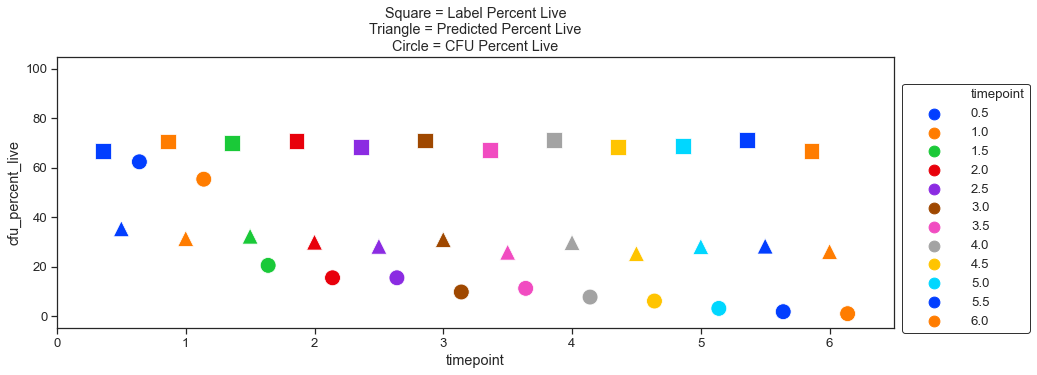

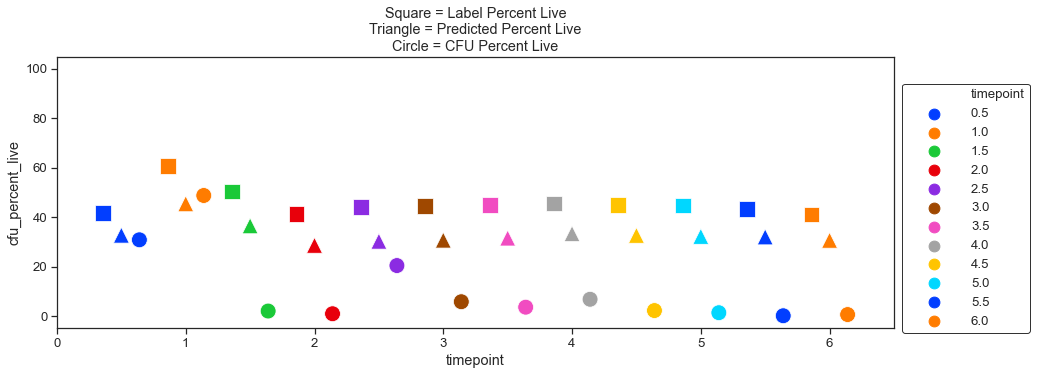

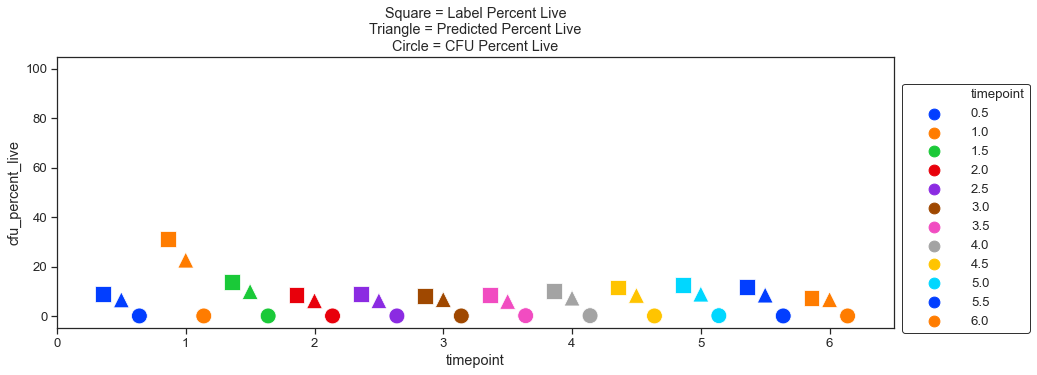

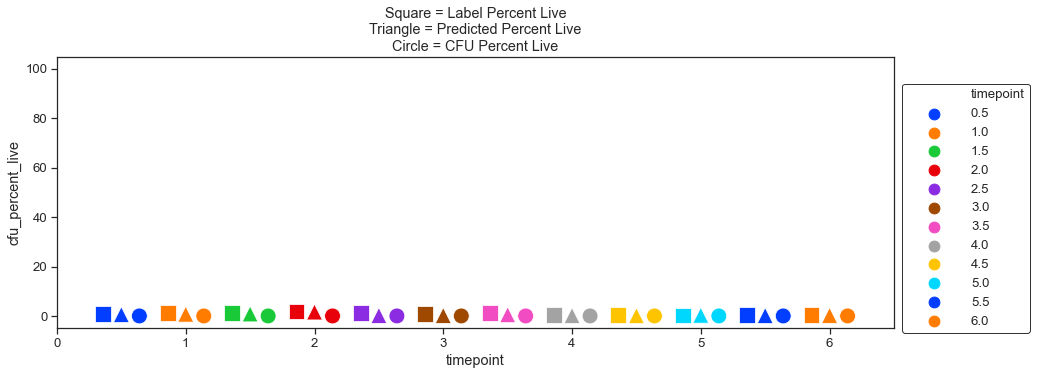

In [173]:
for conc in condition_results[n.inducer_concentration].unique():
    temp = condition_results.loc[condition_results[n.inducer_concentration] == conc]
    plot_percent_live_over_conditions(temp, plot_type="scatter", color_by=n.timepoint, fig_height=5)


Model Boosting took 112.62712025642395 seconds
Training Accuracy = 88.68%
Counter({0: 147967, 1: 111575})


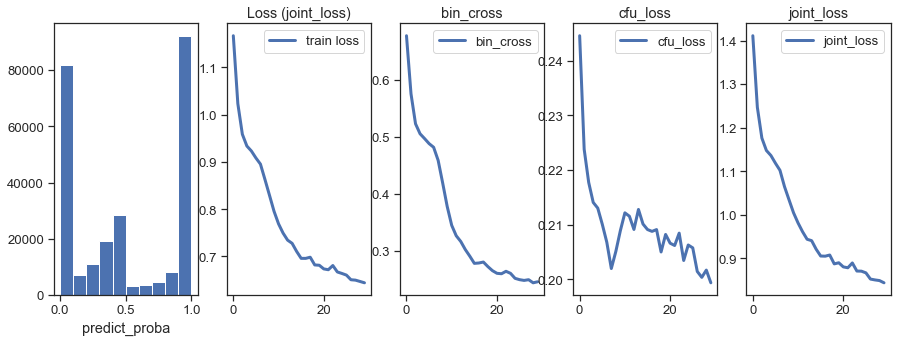

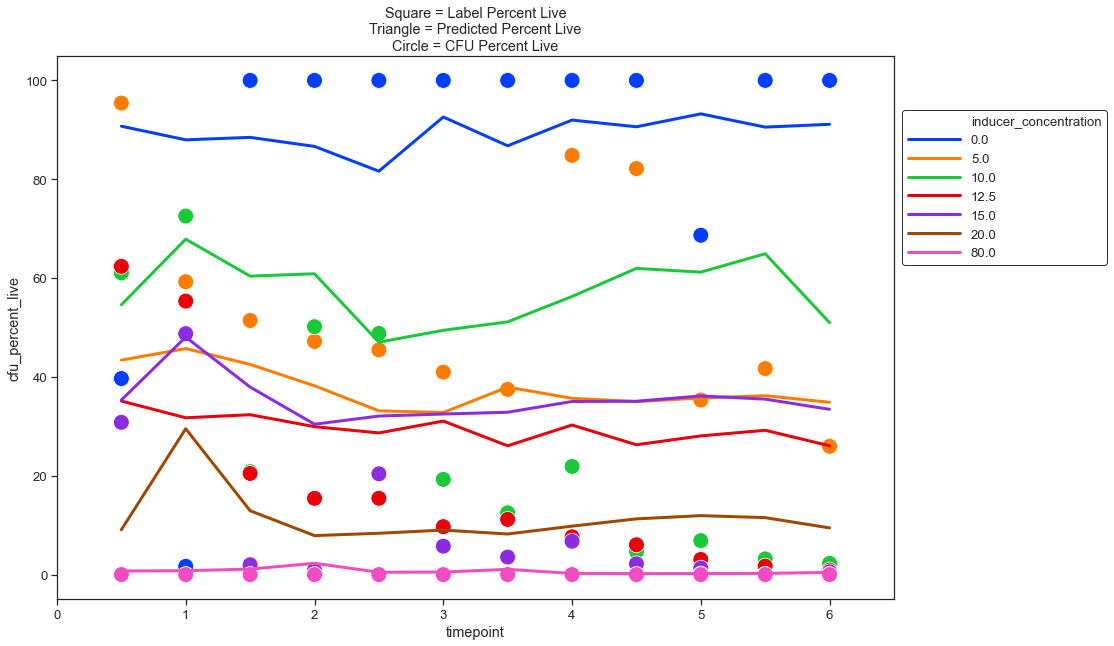

In [168]:
condition_results_2, preds_and_labels_2 = run_model(model_function=booster_model_v2, lr=0.001,
                             loss = joint_loss_wrapper(2), metrics = [bin_cross, cfu_loss, joint_loss],
                             X = X_all, Y = Y_all, epochs = 30, batch_size = 2048,
                             verbose = False, shuffle = True, plot_type="line")

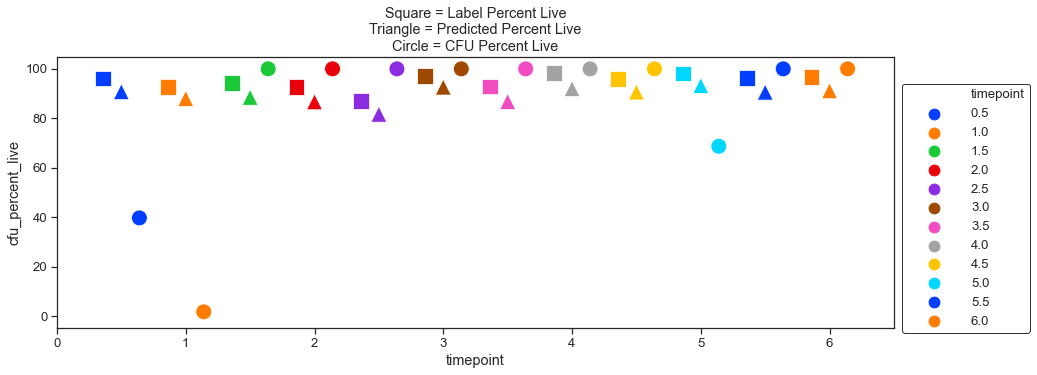

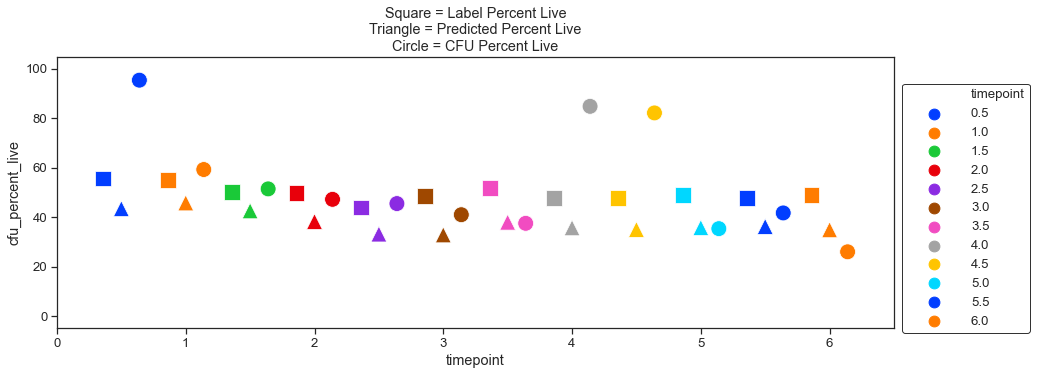

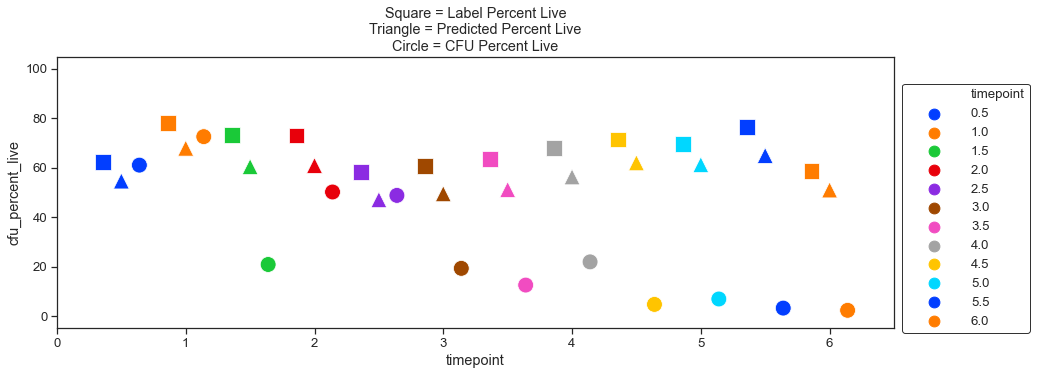

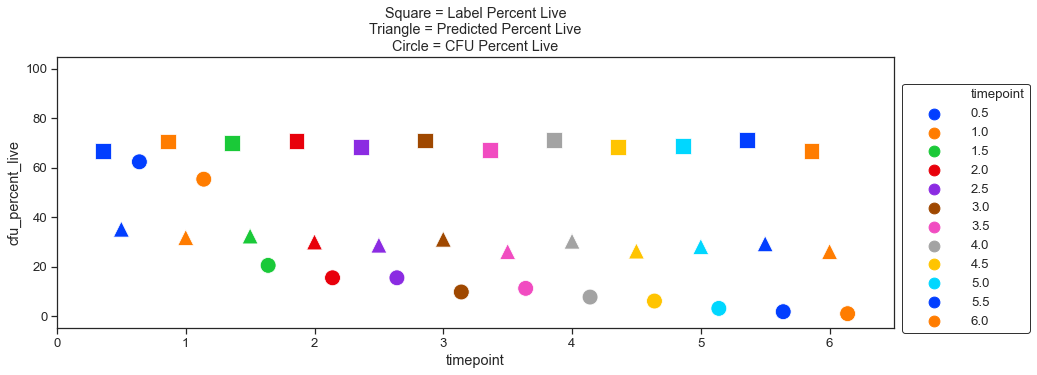

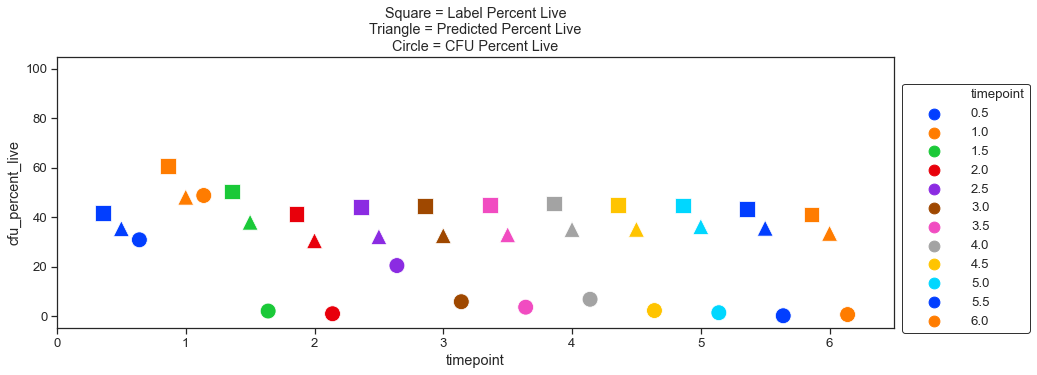

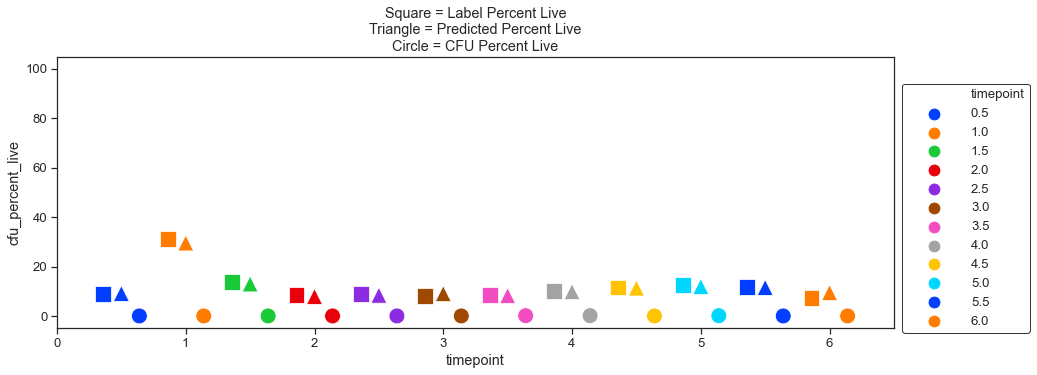

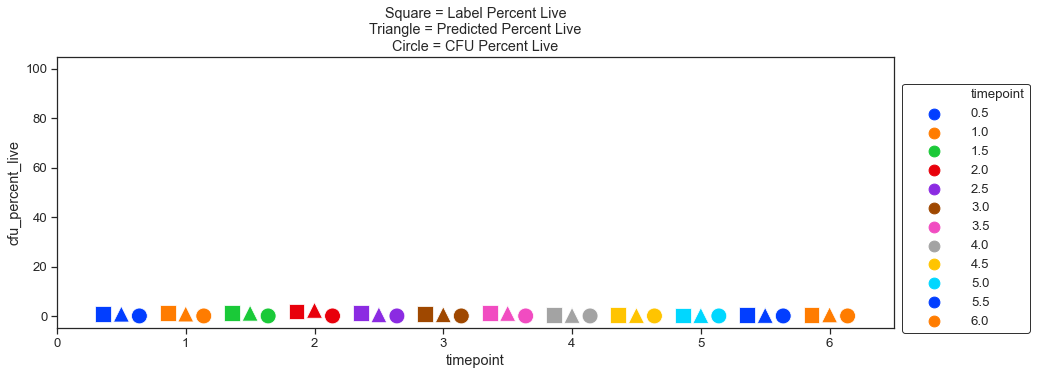

In [169]:
for conc in condition_results_2[n.inducer_concentration].unique():
    temp = condition_results_2.loc[condition_results_2[n.inducer_concentration] == conc]
    plot_percent_live_over_conditions(temp, plot_type="scatter", color_by=n.timepoint, fig_height=5)


Model Boosting took 125.71447515487671 seconds
Training Accuracy = 90.32%
Counter({0: 140548, 1: 118994})


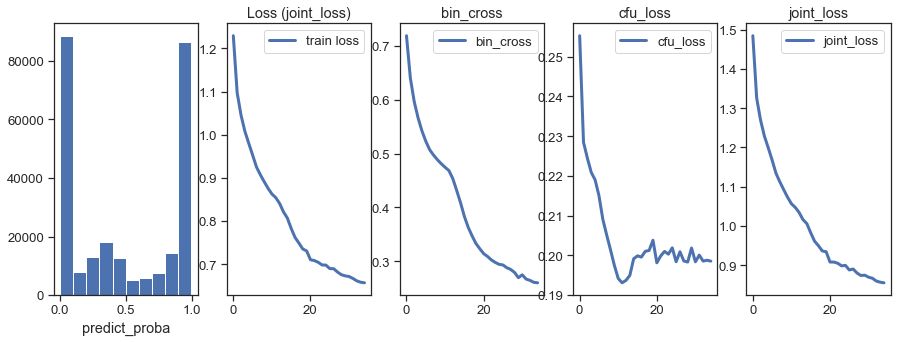

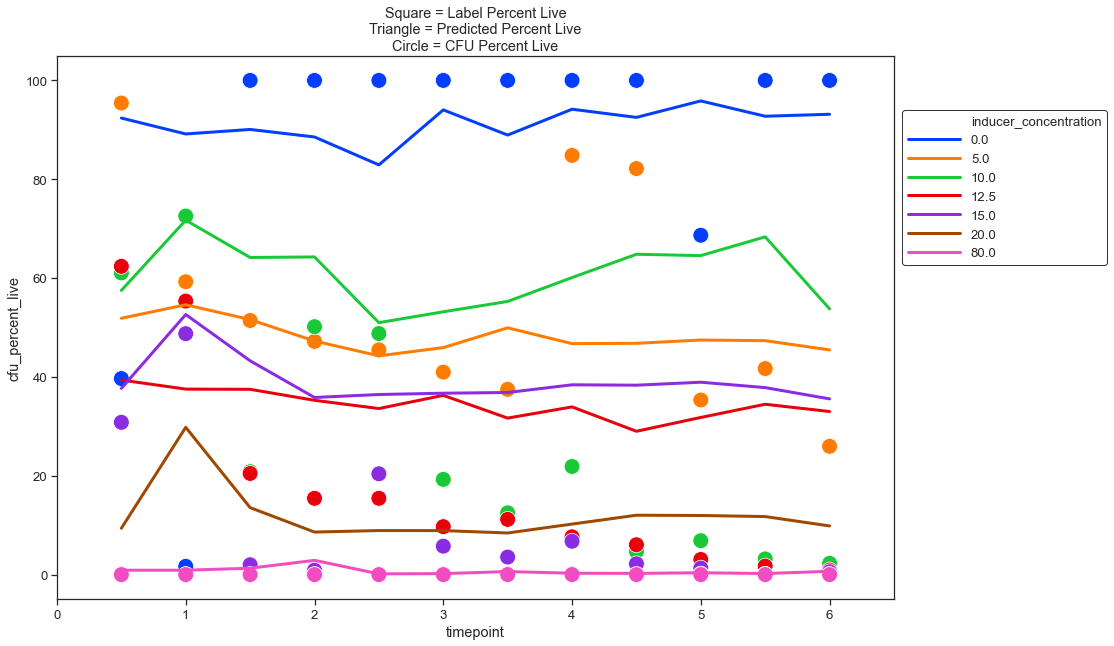

In [170]:
condition_results_3, preds_and_labels_3 = run_model(model_function=booster_model_v2, lr=0.001,
                             loss = joint_loss_wrapper(2), metrics = [bin_cross, cfu_loss, joint_loss],
                             X = X_all, Y = Y_all, epochs = 35, batch_size = 2048,
                             verbose = False, shuffle = True, plot_type="line")

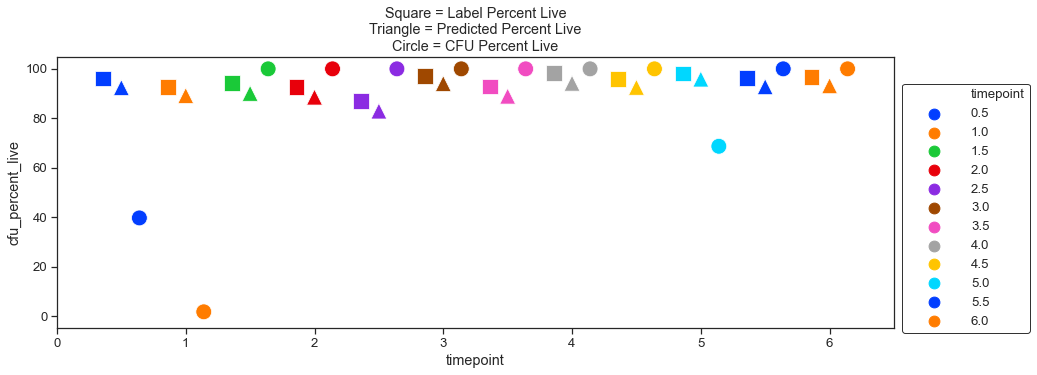

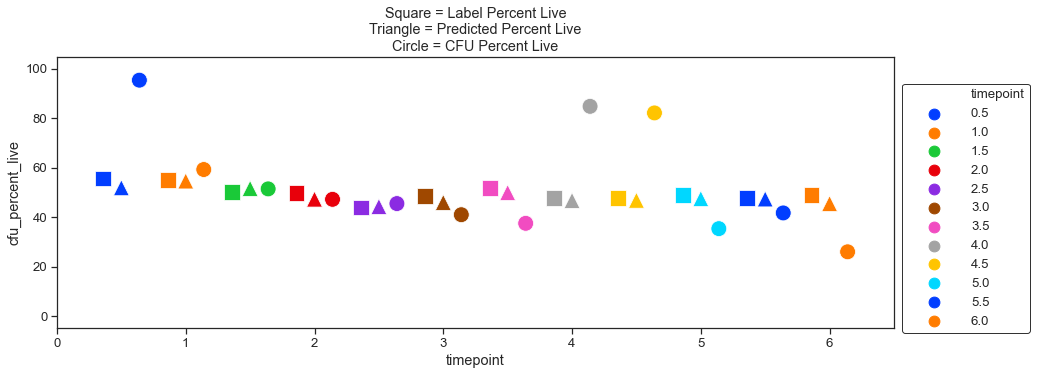

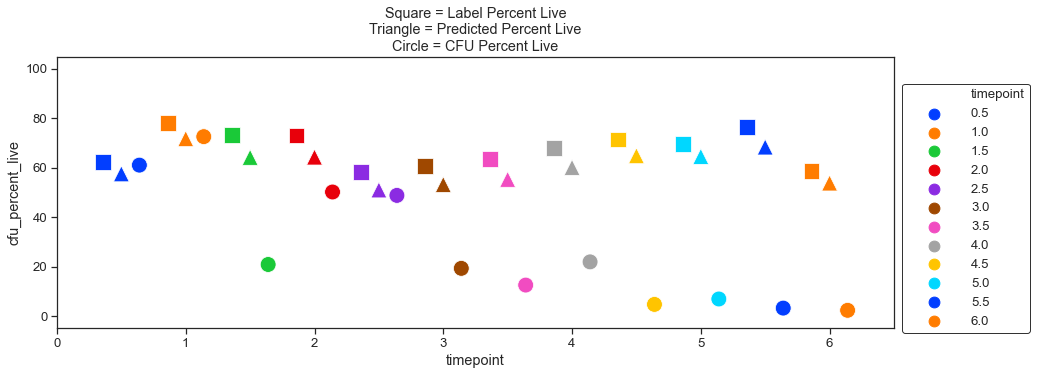

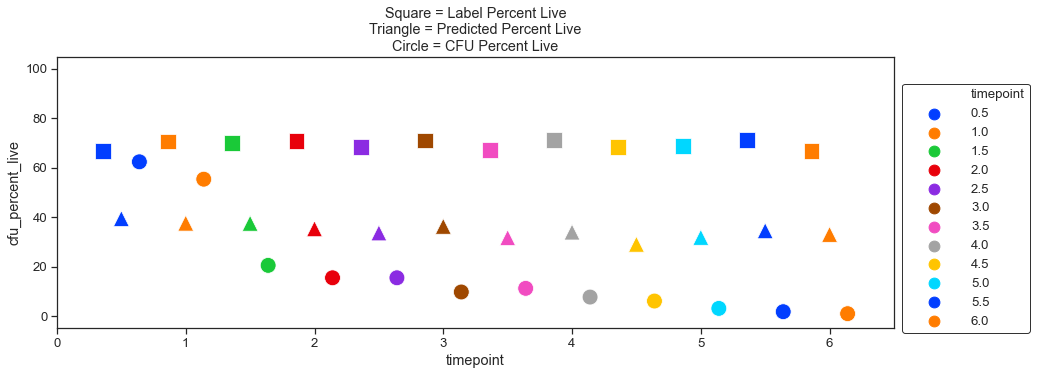

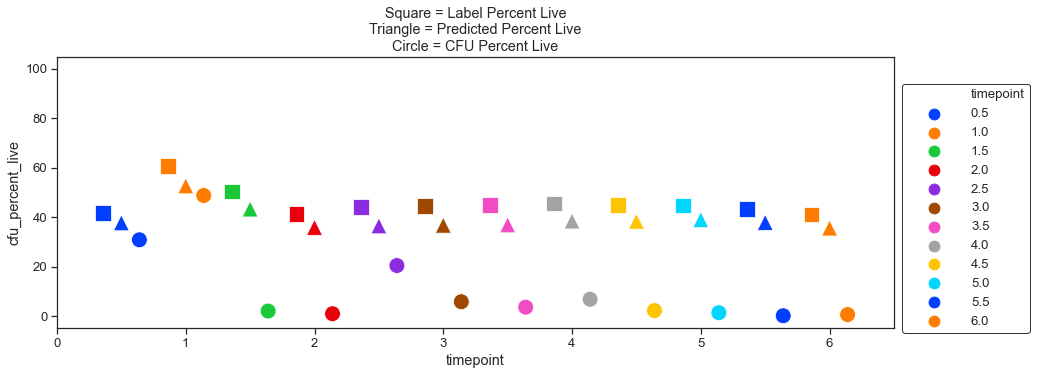

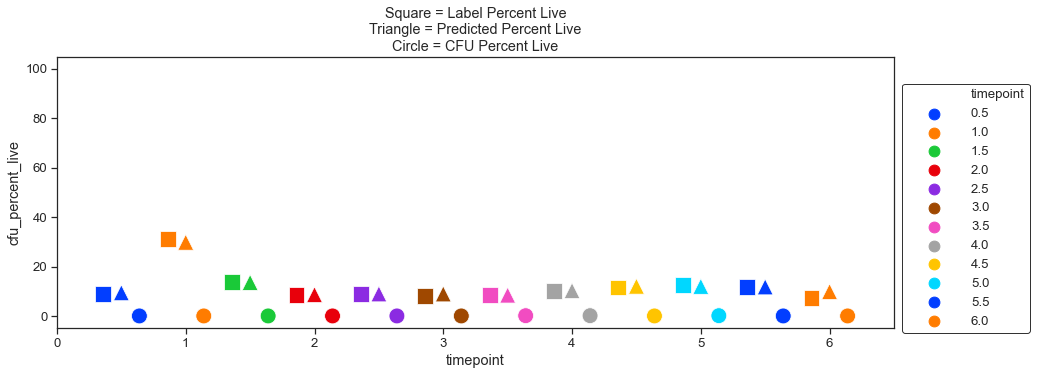

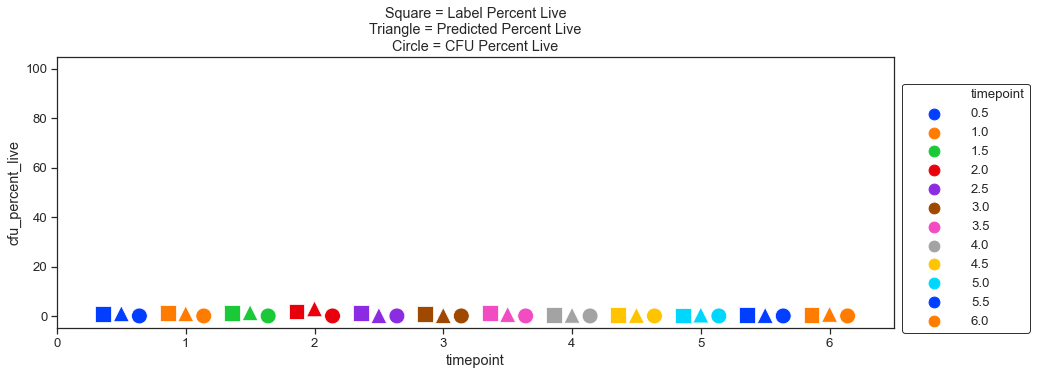

In [171]:
for conc in condition_results_3[n.inducer_concentration].unique():
    temp = condition_results_3.loc[condition_results_3[n.inducer_concentration] == conc]
    plot_percent_live_over_conditions(temp, plot_type="scatter", color_by=n.timepoint, fig_height=5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9

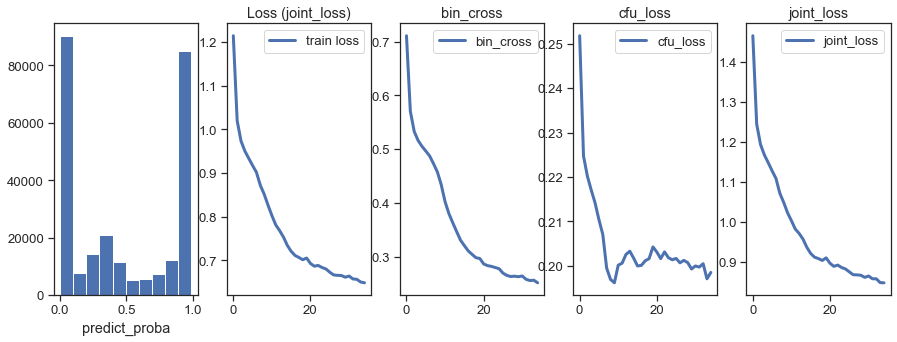

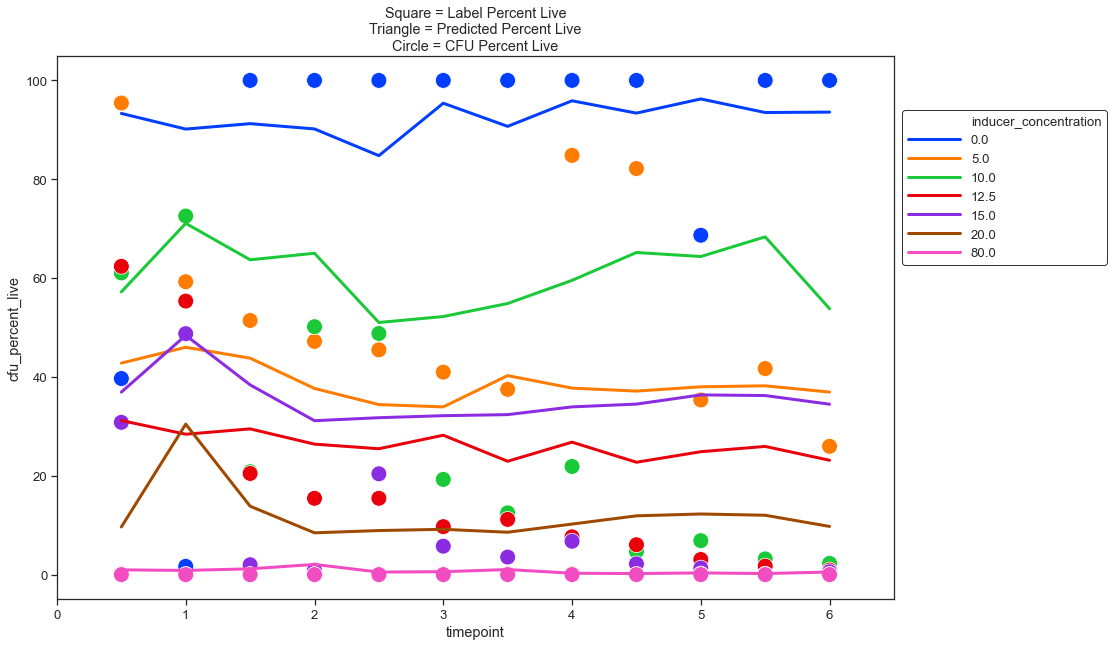

In [176]:
condition_results_4, preds_and_labels_4 = run_model(model_function=booster_model_v2, lr=0.001,
                             loss = joint_loss_wrapper(2), metrics = [bin_cross, cfu_loss, joint_loss],
                             X = X_all, Y = Y_all, epochs = 35, batch_size = 2048,
                             verbose = False, shuffle = True, plot_type="line")

Exploring samples that were shifted by CFU loss

In [ ]:
preds_and_labels_2

In [177]:
concat = pd.concat([X_all, preds_and_labels_2], axis=1)
concat["nn_preds"] = concat["nn_preds"]/100
concat[n.label] = concat[n.label]/100
concat["changed"] = ~(concat["label"] == concat["nn_preds"])
concat["change_type"] = "this_should_be_gone"
concat.loc[(concat["label"] == 0) & (concat["nn_preds"] == 0), "change_type"] = "0_to_0"
concat.loc[(concat["label"] == 1) & (concat["nn_preds"] == 1), "change_type"] = "1_to_1"
concat.loc[(concat["label"] == 0) & (concat["nn_preds"] == 1), "change_type"] = "0_to_1"
concat.loc[(concat["label"] == 1) & (concat["nn_preds"] == 0), "change_type"] = "1_to_0"

concat

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,label,inducer_concentration,timepoint,cfu_percent_live,nn_preds,changed,change_type
0,4.937493,4.852639,1.612784,4.545703,4.432199,1.477121,1.0,0.0,0.5,39.67,1.0,False,1_to_1
1,4.881054,4.769717,1.591065,4.593319,4.483273,1.491362,1.0,0.0,0.5,39.67,1.0,False,1_to_1
2,5.217273,5.056962,1.716003,5.115637,4.985498,1.662758,1.0,0.0,0.5,39.67,1.0,False,1_to_1
3,4.837431,4.795463,1.568202,4.394942,4.333971,1.397940,1.0,0.0,0.5,39.67,0.0,True,1_to_0
4,5.224023,4.771183,1.977724,4.895577,4.490436,1.838849,1.0,0.0,0.5,39.67,1.0,False,1_to_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259537,4.086538,3.939769,0.000000,4.006380,3.955592,0.000000,0.0,80.0,6.0,0.00,0.0,False,0_to_0
259538,6.020599,5.369036,3.009876,6.020599,6.020599,3.009876,0.0,80.0,6.0,0.00,0.0,False,0_to_0
259539,3.429591,3.334454,0.000000,3.146438,2.997386,0.000000,0.0,80.0,6.0,0.00,0.0,False,0_to_0
259540,3.640680,3.509337,0.000000,3.005181,2.911690,0.000000,0.0,80.0,6.0,0.00,0.0,False,0_to_0


In [178]:
concat_sub = concat.loc[(concat[n.inducer_concentration] == 10.0) & (concat[n.timepoint] == 2.0)]

In [ ]:
concat_sub = concat.loc[(concat[n.inducer_concentration] == 20.0) & (concat[n.timepoint] == 1.0)]

In [ ]:
# plt.figure(figsize=(15, 15))
# sns.scatterplot(data=concat_sub, x="FSC-A", y="SSC-A", hue="changed", s=50, alpha=0.7)
# plt.ylim(2,6)

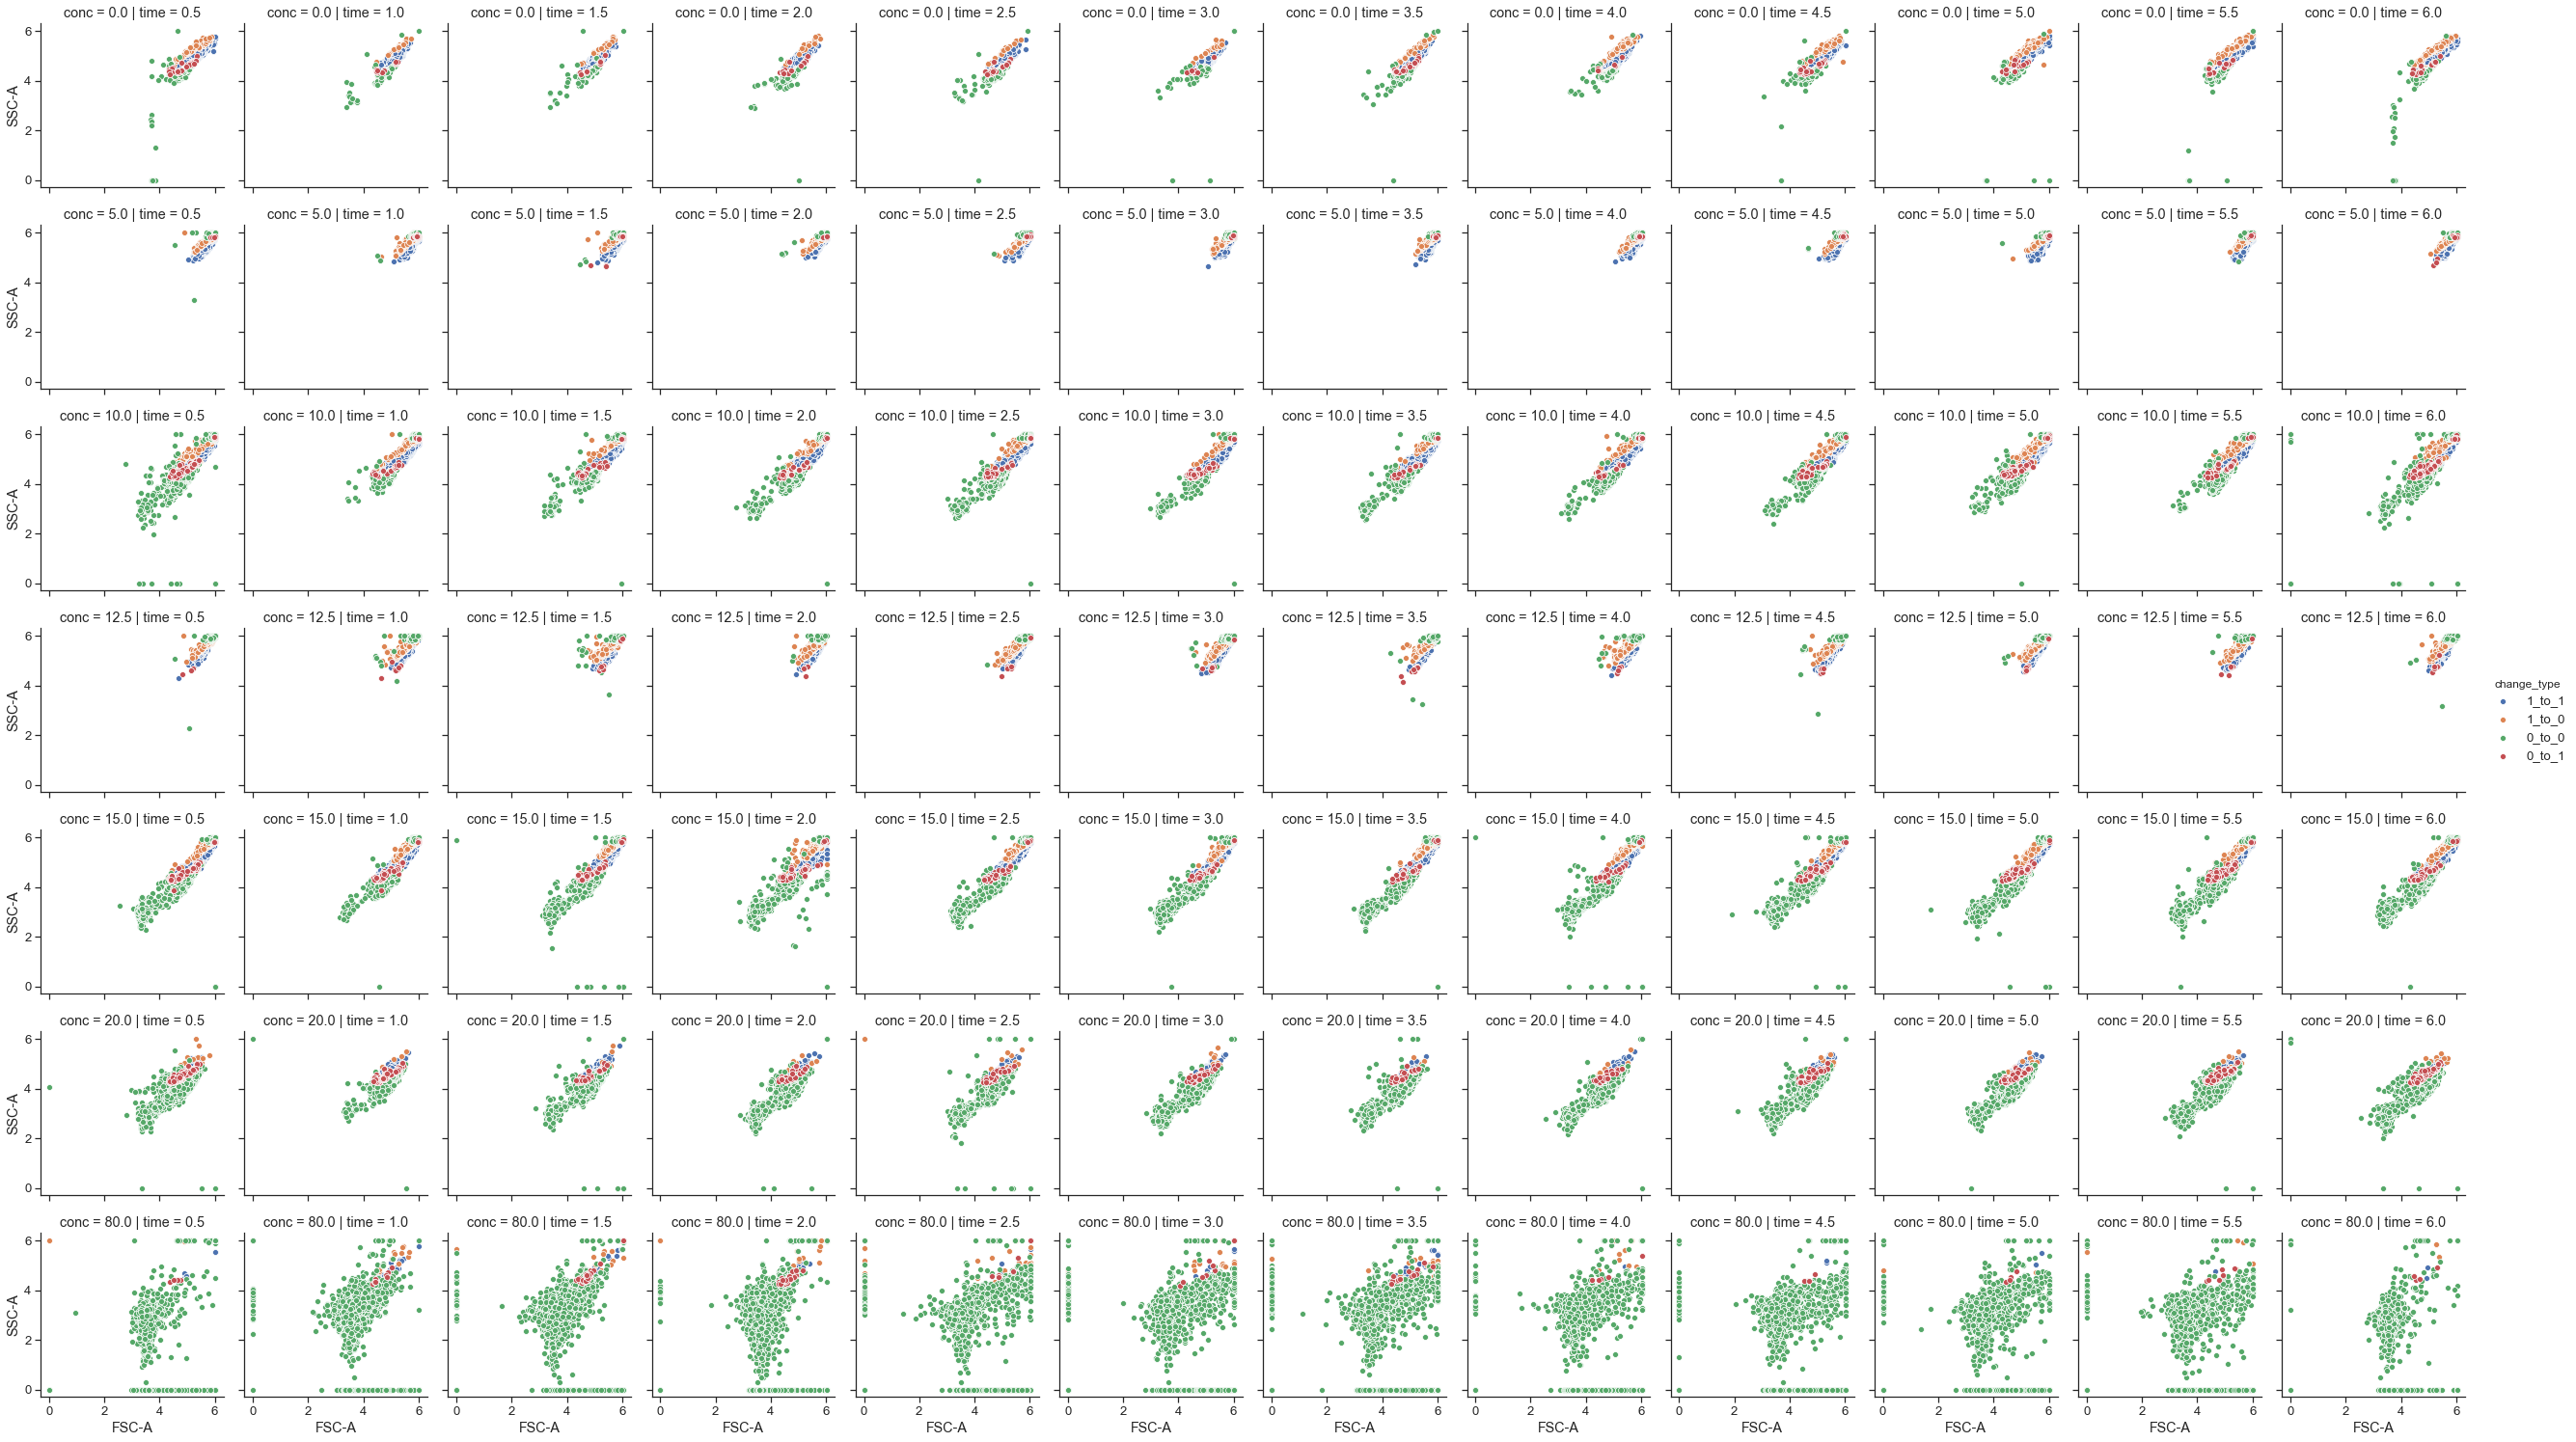

In [179]:
g = sns.FacetGrid(data=concat.rename(columns={n.inducer_concentration: "conc", n.timepoint: "time"}), 
                  col="time",  row="conc", hue="change_type")
g.map(sns.scatterplot, "FSC-A", "SSC-A")
g.add_legend()

In [ ]:
# g = sns.FacetGrid(data=concat.rename(columns={n.inducer_concentration: "conc", n.timepoint: "time"}).loc[~(concat["change_type"] == "unchanged")], 
#                   col="time",  row="conc", hue="change_type")
# g.map(sns.scatterplot, "FSC-A", "SSC-A")
# g.set(xlim=(3.5, 6), ylim=(3.5, 6))
# g.add_legend()

In [ ]:
print()

In [ ]:
pp = sns.PairGrid(concat_sub.rename(columns={n.inducer_concentration: "conc", n.timepoint: "time"}),
                  hue="change_type", vars=features, height=2.5)
pp.map_upper(sns.scatterplot)
pp.map_lower(sns.kdeplot)
pp.map_diag(sns.kdeplot, lw=1)
pp.add_legend()

In [ ]:
sns.pairplot(concat_sub.rename(columns={n.inducer_concentration: "conc", n.timepoint: "time"}),
             hue="change_type", vars=features, height=2.5)

In [ ]:
sns.pairplot(concat_sub.rename(columns={n.inducer_concentration: "conc", n.timepoint: "time"}),
             hue="change_type", x_vars=features[:3], y_vars=features[3:], height=5)

## Compare Labels: Baseline (RF) vs. Boosted vs. Random

In [ ]:
concat

In [ ]:
concat['nn_percent_live'] = concat.groupby([n.inducer_concentration, n.timepoint])["nn_preds"].transform('mean') * 100

In [ ]:
concat["label_probs"] = df_all["label_probs"]
concat

In [ ]:
zero_to_zero = concat.loc[concat["change_type"]=="0_to_0", "label_probs"]
one_to_one = concat.loc[concat["change_type"]=="1_to_1", "label_probs"]
zero_to_one = concat.loc[concat["change_type"]=="0_to_1", "label_probs"]
one_to_zero = concat.loc[concat["change_type"]=="1_to_0", "label_probs"]

sns.distplot(zero_to_zero, bins=100, label="0_to_0")
sns.distplot(one_to_one, bins=100, label="1_to_1")
sns.distplot(zero_to_one, bins=100, label="0_to_1")
sns.distplot(one_to_zero, bins=100, label="1_to_0")
plt.legend()

In [ ]:
sns.distplot(zero_to_zero, bins=100, label="0_to_0")
sns.distplot(one_to_one, bins=100, label="1_to_1")
sns.distplot(zero_to_one, bins=100, label="0_to_1")
sns.distplot(one_to_zero, bins=100, label="1_to_0")
plt.legend()
plt.ylim(0, 15)

In [ ]:
condition_results_cfu = run_model(model_function=booster_model_v2, lr=0.001,
                              loss = cfu_loss, metrics = [bin_cross, cfu_loss, joint_loss],
                              X = X_all, Y = Y_all, epochs = 25, batch_size = 1024, verbose = True, shuffle = True)

In [ ]:
condition_results_cfu = condition_results_cfu.reset_index()

In [ ]:
for conc in condition_results_cfu[n.inducer_concentration].unique():
    temp = condition_results_cfu.loc[condition_results_cfu[n.inducer_concentration] == conc]
    plot_percent_live_over_conditions(temp)